# Neural network fundamentals
## Activation functions
### Definitions

In [1]:
import numpy as np
from typing import Callable

# Activation functions for neural networks
# Each function takes a numpy array and returns a transformed array

# Sigmoid: smooth S-curve that maps any real value to (0,1)
# Commonly used for binary classification output layers
sigmoid: Callable[[np.ndarray], np.ndarray] = lambda x: 1 / (1 + np.exp(-x))

# ReLU: rectified linear unit that zeros out negative values
# Most popular activation for hidden layers due to computational efficiency
relu: Callable[[np.ndarray], np.ndarray] = lambda x: np.maximum(0, x)

# Jump/Step: binary threshold function outputting 0 or 1
# Simple decision boundary for binary classification
jump: Callable[[np.ndarray], np.ndarray] = lambda x: np.where(x > 0, 1.0, 0.0)

### Plots

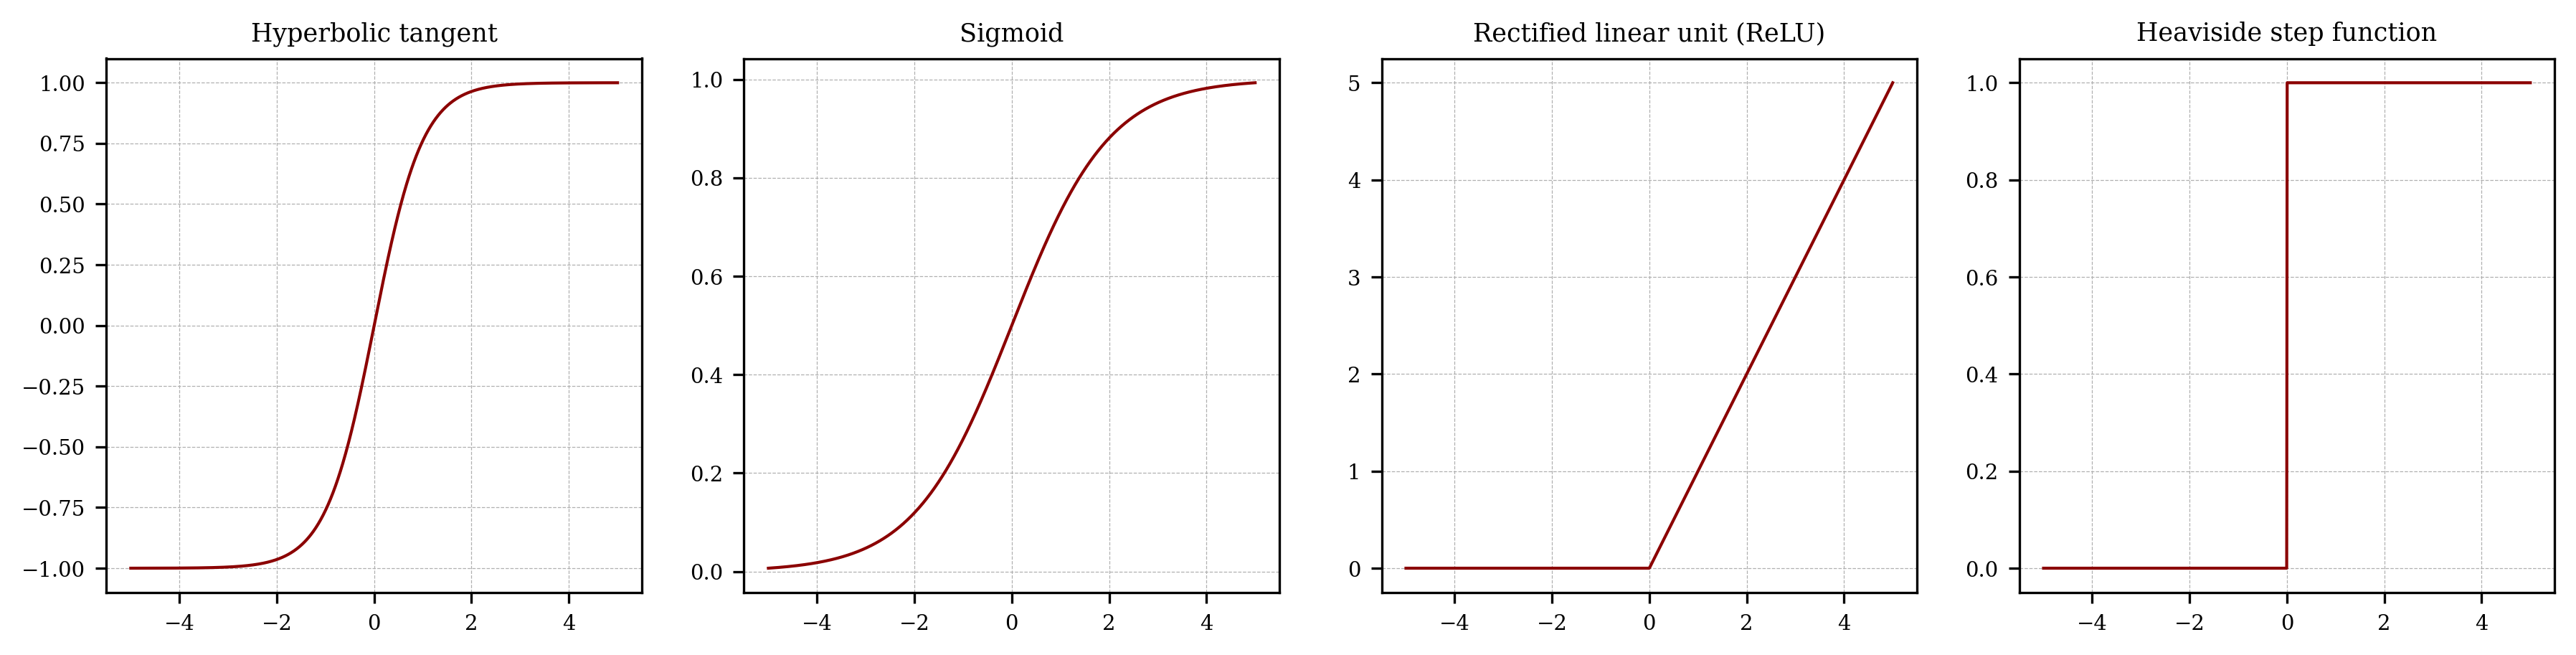

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Configure matplotlib for publication-quality plots
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 7
plt.rcParams["figure.dpi"] = 300

# Define activation functions and their display names
functions = [np.tanh, sigmoid, relu, jump]
titles = [
    "Hyperbolic tangent",
    "Sigmoid",
    "Rectified linear unit (ReLU)",
    "Heaviside step function",
]

# Create subplot grid for comparing activation functions
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
fig.tight_layout(pad=1.5)

# Generate input range and plot each activation function
x = np.linspace(-5, 5, 1000)
for ax, func, tit in zip(axes, functions, titles):
    ax.plot(x, func(x), color="darkred", linewidth=1)
    ax.set_title(tit)
    ax.grid(True, linestyle="--", linewidth=0.3)

## Single-layer neural network
### Layer implementation

In [3]:
import numpy as np
from typing import Literal

# Define supported activation function types for type safety
ActivationType = Literal["linear", "tanh", "sigmoid", "relu", "jump"]


def activate(
    input_vector: np.ndarray,
    weight_matrix: np.ndarray,
    bias_vector: np.ndarray,
    activation: ActivationType = "tanh",
) -> np.ndarray:
    """
    Apply layer transformation with activation.

    Args:
        input_vector: Input vector of shape (input_size,)
        weight_matrix: Weight matrix of shape (output_size, input_size)
        bias_vector: Bias vector of shape (output_size,)
        activation: Activation function name (default: "tanh")

    Returns:
        Output vector of shape (output_size,)

    Raises:
        ValueError: If activation function is not supported
    """
    # Compute linear transformation: z = Wx + b
    z: np.ndarray = weight_matrix @ input_vector + bias_vector

    # Apply specified activation function
    if activation == "linear":
        return z
    elif activation == "tanh":
        return np.tanh(z)
    elif activation == "sigmoid":
        return sigmoid(z)
    elif activation == "relu":
        return relu(z)
    elif activation == "jump":
        return jump(z)
    else:
        raise ValueError(f"Unsupported activation function: {activation}")

### Output test

In [4]:
import numpy as np

# Define network architecture: 3 inputs -> 2 outputs
dims = [3, 2]

# Initialize random parameters with fixed seed for reproducibility
np.random.seed(42)
bias_vector = np.random.randn(dims[1])
weight_matrix = np.random.randn(dims[1], dims[0])
input_vector = np.random.randn(dims[0])

# Test different activation functions on the same linear transformation
output_unactivated = weight_matrix @ input_vector + bias_vector
output_linear = activate(input_vector, weight_matrix, bias_vector, activation="linear")
output_jump = activate(input_vector, weight_matrix, bias_vector, activation="jump")
output_sigmoid = activate(
    input_vector, weight_matrix, bias_vector, activation="sigmoid"
)

# Display all components and results for comparison
print(f"Input vector:\n {input_vector}")
print(f"Weight matrix:\n {weight_matrix}")
print(f"Bias vector:\n {bias_vector}")
print(f"Output unactivated:\n {output_unactivated}")
print(f"Output using jump activation:\n {output_jump}")
print(f"Output using linear activation:\n {output_linear}")
print(f"Output using sigmoid activation:\n {output_sigmoid}")

Input vector:
 [-0.46947439  0.54256004 -0.46341769]
Weight matrix:
 [[ 0.64768854  1.52302986 -0.23415337]
 [-0.23413696  1.57921282  0.76743473]]
Bias vector:
 [ 0.49671415 -0.1382643 ]
Output unactivated:
 [1.12748694 0.47283195]
Output using jump activation:
 [1. 1.]
Output using linear activation:
 [1.12748694 0.47283195]
Output using sigmoid activation:
 [0.75537482 0.61605382]


### Output visualization

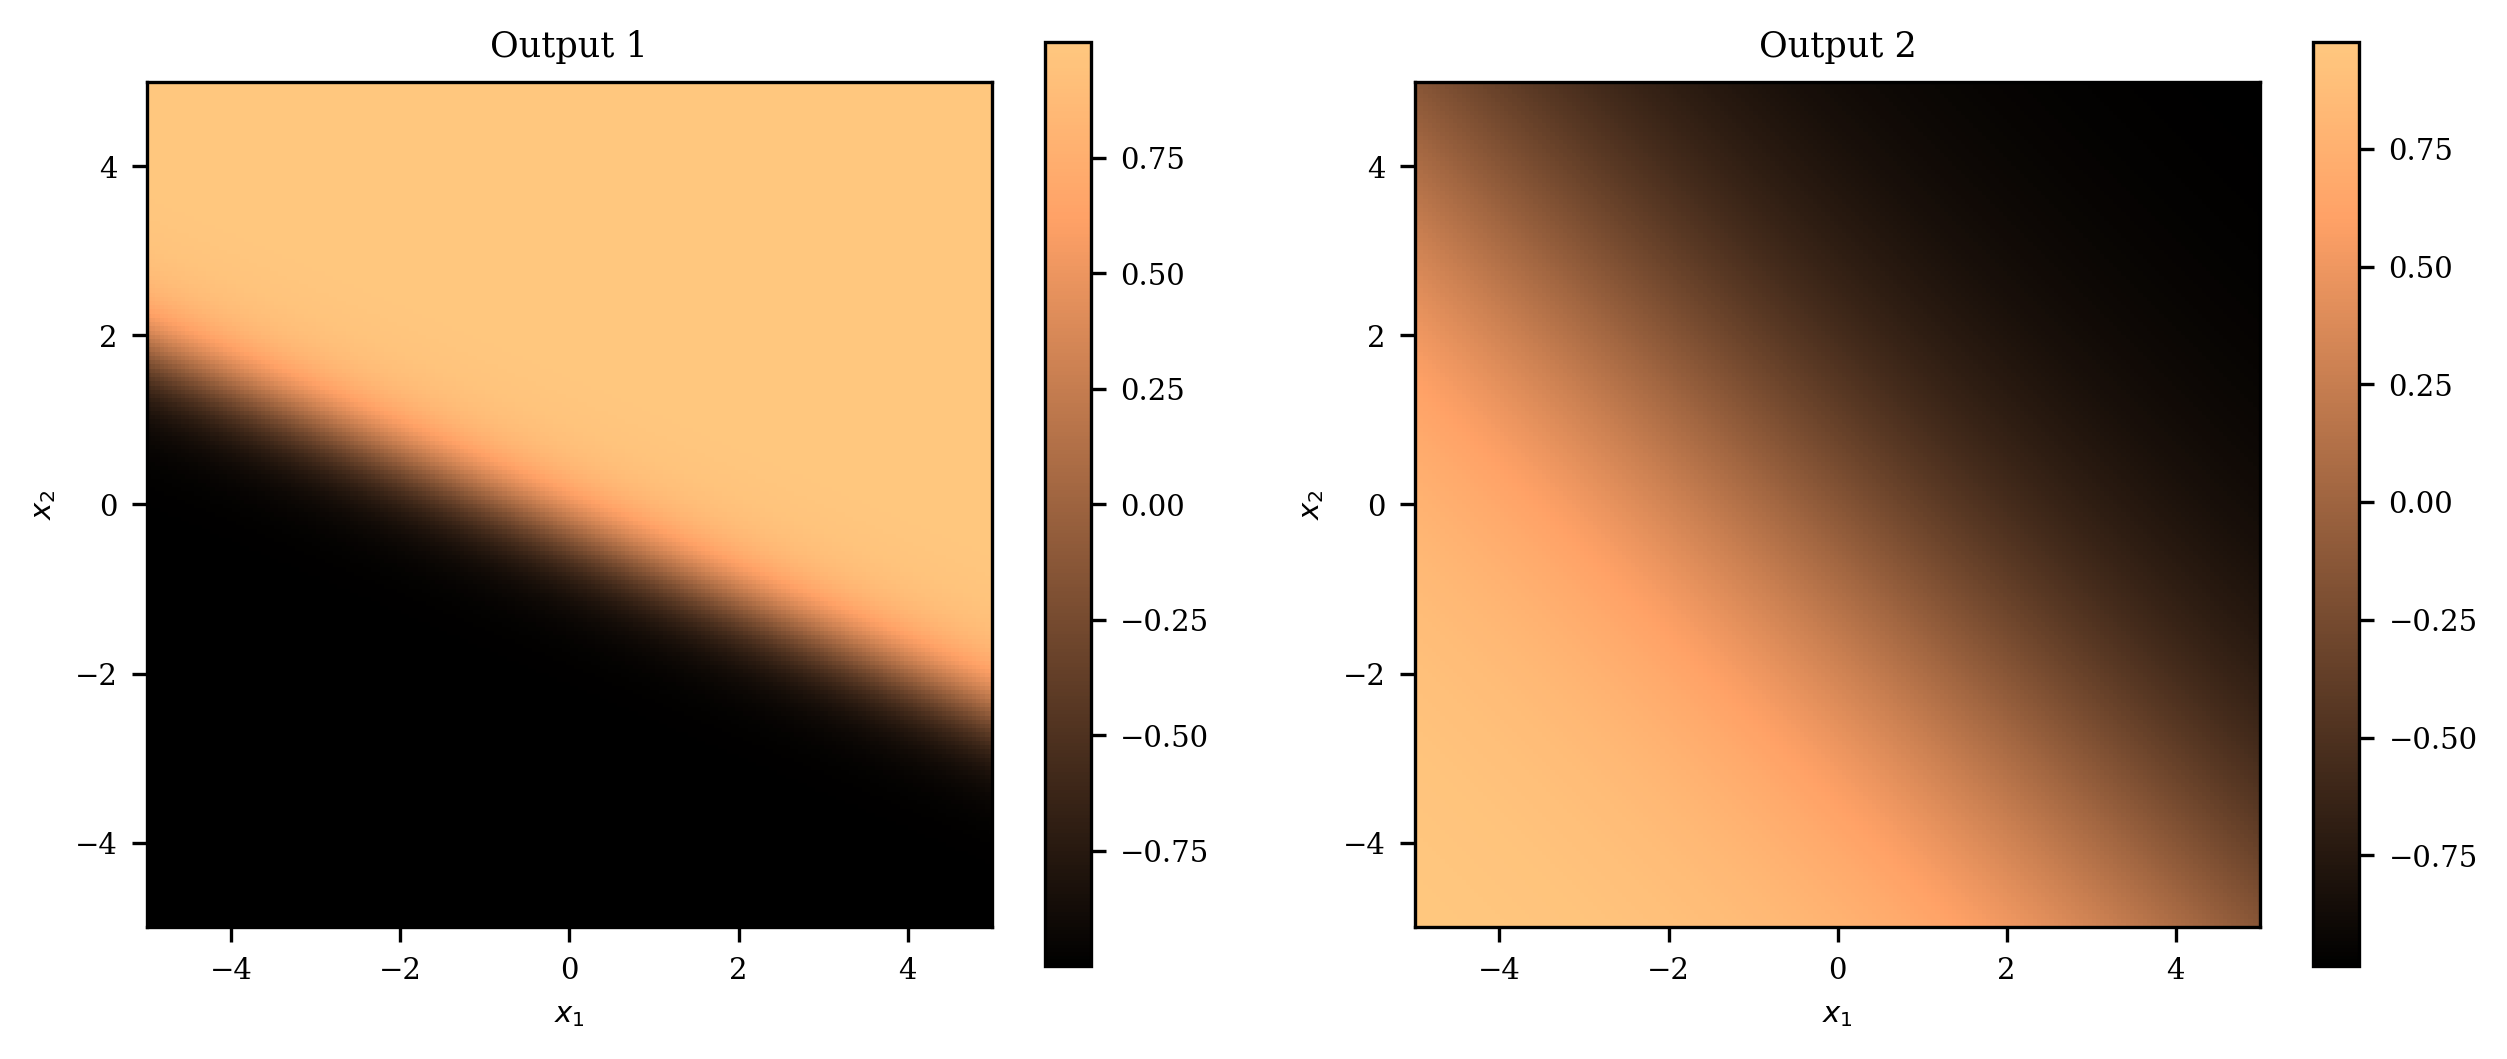

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define 2D to 2D network architecture
dims = [2, 2]

np.random.seed(42)

# Initialize layer parameters
bias_vector = np.random.randn(dims[1])
weight_matrix = np.random.randn(dims[1], dims[0])

# Create 2D input grid for visualization
n = 200
x1_range = np.linspace(-5, 5, n)
x2_range = np.linspace(-5, 5, n)
x1_flat, x2_flat = np.meshgrid(x1_range, x2_range)
input_points = np.vstack([x1_flat.ravel(), x2_flat.ravel()])

# Batch processing explanation:
# - input_points shaped (2, n²) for matrix multiplication W @ X
# - bias_vector[:, np.newaxis] reshapes (2,) to (2, 1) for broadcasting
# - adds bias[0] to first neuron, bias[1] to second neuron across all samples

# Compute network outputs for all grid points
outputs_raw = activate(input_points, weight_matrix, bias_vector[:, np.newaxis])
outputs = [outputs_raw[0].reshape(x1_flat.shape), outputs_raw[1].reshape(x2_flat.shape)]
titles = ["Output 1", "Output 2"]

# Visualize neural network outputs as heatmaps
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, output, title in zip(axes, outputs, titles):
    im = ax.imshow(output, extent=[-5, 5, -5, 5], origin="lower", cmap="copper")
    ax.set_title(title)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    fig.colorbar(im, ax=ax)

## Alternative implementation with JAX vectorization

In [6]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from typing import Literal, Callable

# Configure matplotlib for publication-quality plots
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 7
plt.rcParams["figure.dpi"] = 300

# Type aliases for cleaner function signatures
ActivationType = Literal["linear", "tanh", "sigmoid", "relu", "jump"]

# JAX-compatible activation functions using jnp operations
sigmoid: Callable[[jnp.ndarray], jnp.ndarray] = lambda x: 1 / (1 + jnp.exp(-x))
relu: Callable[[jnp.ndarray], jnp.ndarray] = lambda x: jnp.maximum(0, x)
jump: Callable[[jnp.ndarray], jnp.ndarray] = lambda x: jnp.where(x > 0, 1.0, 0.0)


def activate(
    input_vector: jnp.ndarray,
    weight_matrix: jnp.ndarray,
    bias_vector: jnp.ndarray,
    activation: ActivationType = "relu",
) -> jnp.ndarray:
    """
    Apply layer transformation with activation.

    Args:
        input_vector: Input vector of shape (input_size,)
        weight_matrix: Weight matrix of shape (output_size, input_size)
        bias_vector: Bias vector of shape (output_size,)
        activation: Activation function name

    Returns:
        Output vector of shape (output_size,)
    """
    # Compute linear transformation: z = Wx + b
    z = jnp.dot(weight_matrix, input_vector) + bias_vector

    # Apply specified activation function
    if activation == "linear":
        return z
    elif activation == "tanh":
        return jnp.tanh(z)
    elif activation == "sigmoid":
        return sigmoid(z)
    elif activation == "relu":
        return relu(z)
    elif activation == "jump":
        return jump(z)
    else:
        raise ValueError(f"Unsupported activation function: {activation}")


# Vectorize activate() for efficient batch processing
# in_axes=(0, None, None, None) vectorizes over first arg, broadcasts others
_activate_vectorized = jax.vmap(activate, in_axes=(0, None, None, None))


def activate_vectorized(
    input_vector: jnp.ndarray,
    weight_matrix: jnp.ndarray,
    bias_vector: jnp.ndarray,
    activation: Literal["linear", "tanh", "sigmoid", "relu", "jump"] = "relu",
) -> jnp.ndarray:
    """
    Apply layer transformation to multiple inputs in parallel.

    Args:
        input_vector: Input vectors of shape (batch_size, input_size)
        weight_matrix: Weight matrix of shape (output_size, input_size)
        bias_vector: Bias vector of shape (output_size,)
        activation: Activation function name

    Returns:
        Output vectors of shape (batch_size, output_size)
    """
    return _activate_vectorized(input_vector, weight_matrix, bias_vector, activation)

### Implementation using JAX: output visualization

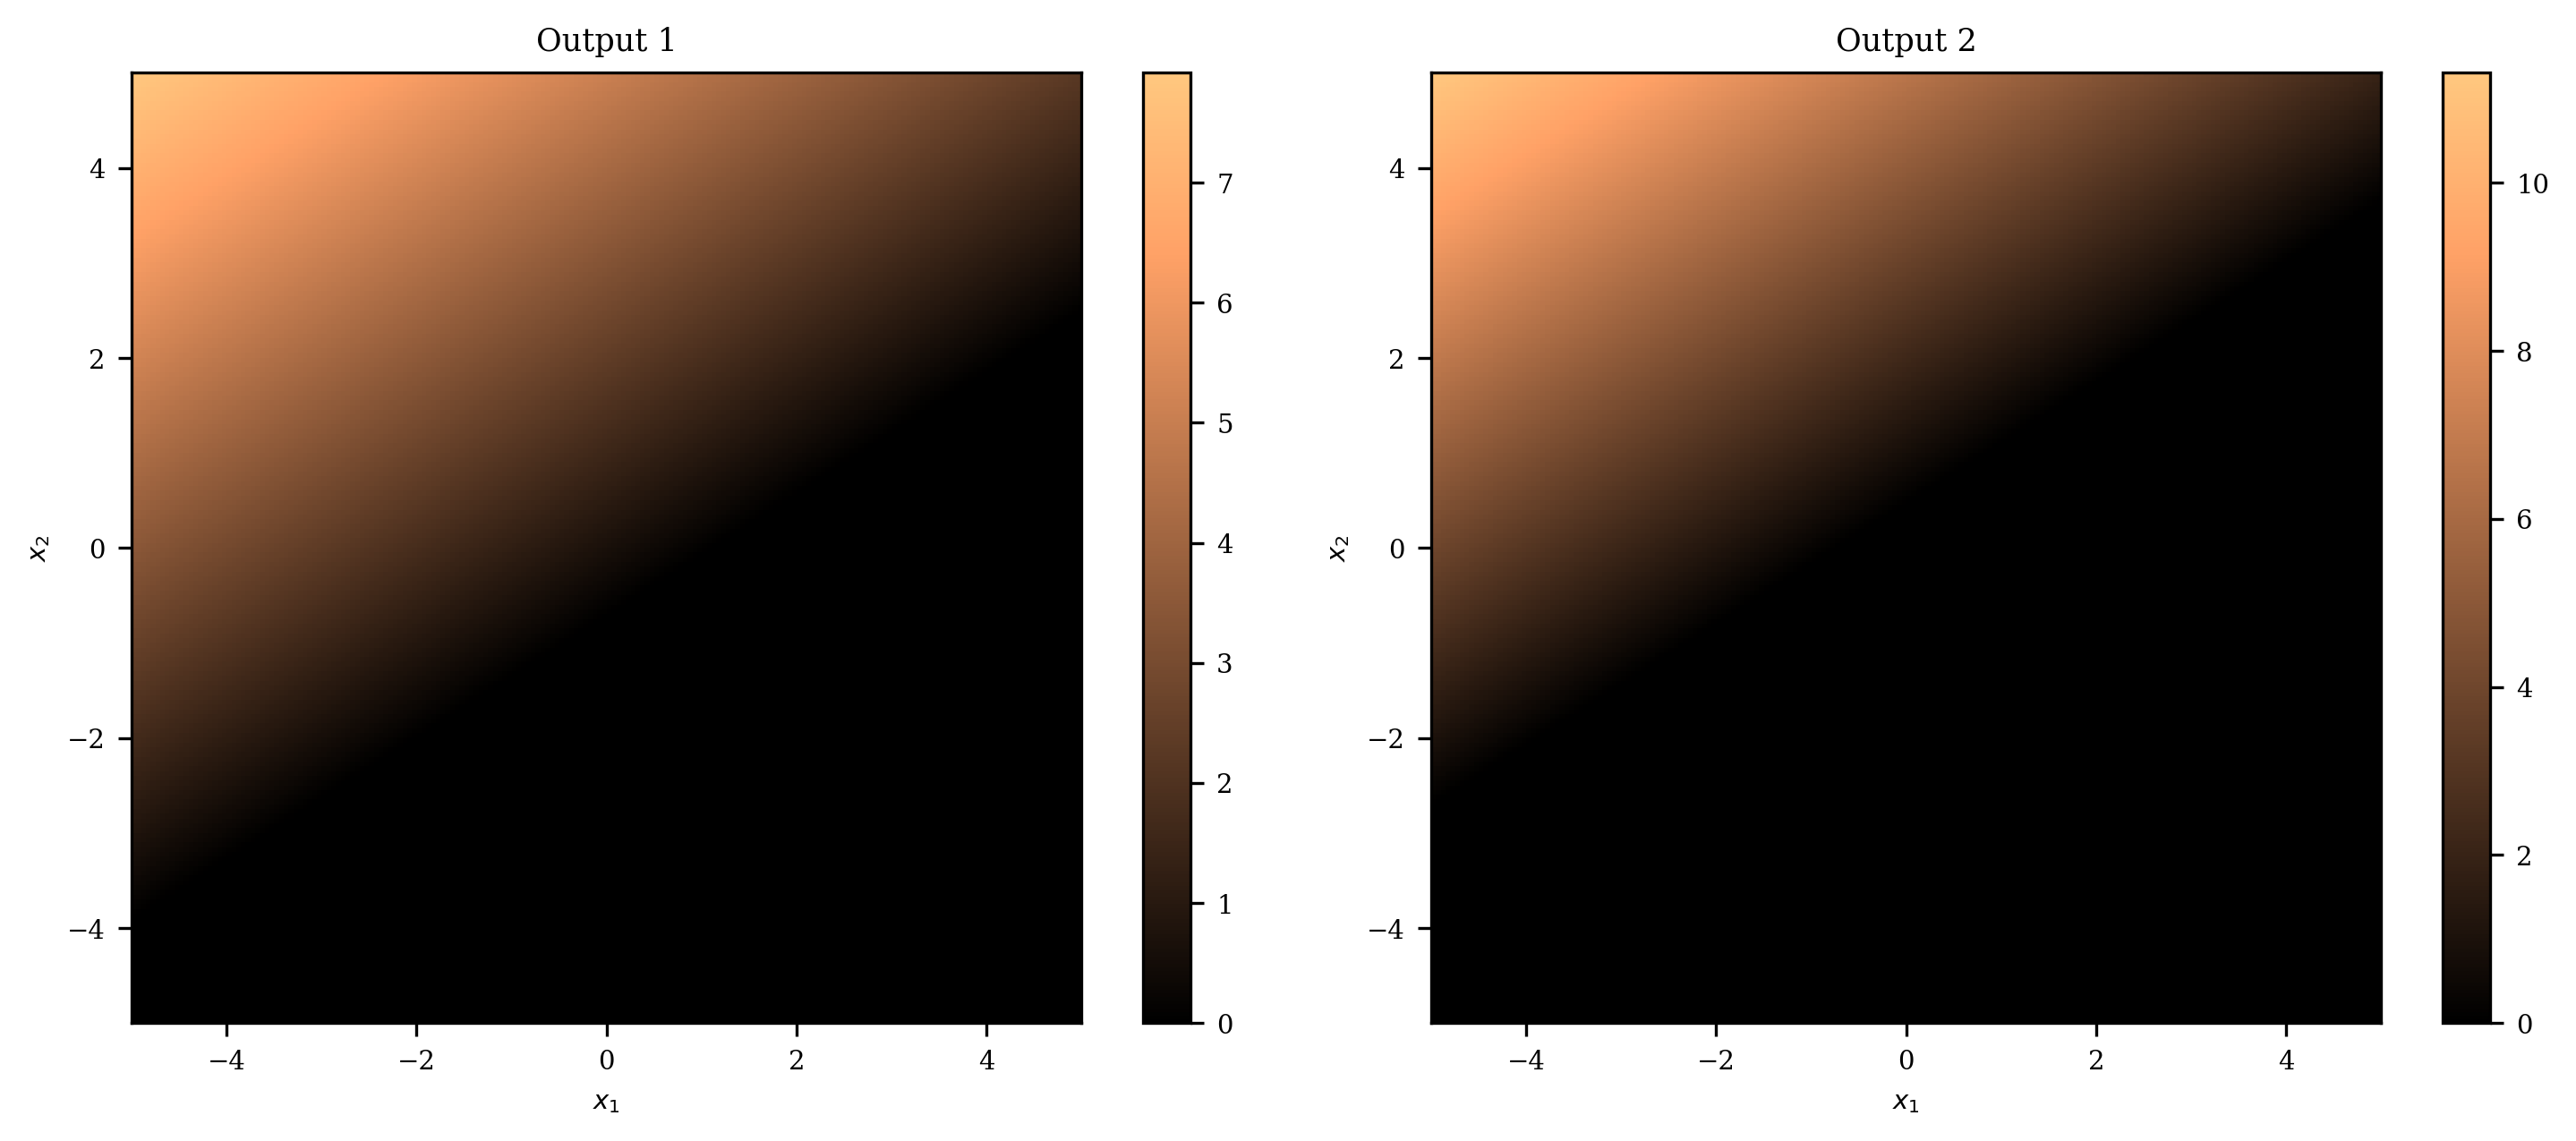

In [7]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Define 2D to 2D network architecture
dims: list[int] = [2, 2]

# Initialize parameters using JAX random number generation
key = jax.random.PRNGKey(42)
key1, key2 = jax.random.split(key)
bias_vector: jnp.ndarray = jax.random.normal(key1, shape=(dims[1],))
weight_matrix: jnp.ndarray = jax.random.normal(key2, shape=(dims[1], dims[0]))

# Create 2D input grid for visualization
resolution: int = 200
x1_range: jnp.ndarray = jnp.linspace(-5, 5, resolution)
x2_range: jnp.ndarray = jnp.linspace(-5, 5, resolution)
x1_flat: jnp.ndarray
x2_flat: jnp.ndarray
x1_flat, x2_flat = jnp.meshgrid(x1_range, x2_range)

# Prepare input for batch processing: shape (resolution², 2)
input_points: jnp.ndarray = jnp.vstack([x1_flat.ravel(), x2_flat.ravel()]).T

# Compute network outputs for all grid points using vectorized function
output_flat: jnp.ndarray = activate_vectorized(
    input_points, weight_matrix, bias_vector
).T

# Reshape outputs back to 2D grid for visualization
outputs: list[jnp.ndarray] = [
    output_flat[0].reshape(resolution, resolution),
    output_flat[1].reshape(resolution, resolution),
]

# Create side-by-side heatmap visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
titles: list[str] = ["Output 1", "Output 2"]

for ax, output, title in zip(axes, outputs, titles):
    im = ax.imshow(output, extent=[-5, 5, -5, 5], origin="lower", cmap="copper")
    ax.set_title(title)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()